# 02_PV_02a_Project_network_Voronois (Uses function voronoi_polygons())

__This notebook is not the final used version__. 
The final used version can be found in the __vref_walkability_index repository.__
__Notebook 02_PV_02b_Population (voronoi_points_within_aoi()).ipynb__

This notebook __loads pop data__ (Looking for population and density) and __distributes it to Voronoi polygons created from nodes__ of the project network from 01_PL_04.

__Required input files__:
* __guadalajara_nodes_proj_net_rebuilt.gpkg__ (From notebook 01_PL_04_Combine_networks.ipynb)
* __pobcenso_inegi_20_mzaageb_mza_gdl.gpkg__ (Input blocks with population data)
  
__Output files:__
* __guadalajara_voronois_pop_gdf_a.gpkg__ (Voronoi polygons with pop data for the project_network)

In [ ]:
# Function developed by Medellin's team. 
# Most updated function: voronoi_points_within_aoi())

def voronoi_polygons(nodes:gpd.GeoDataFrame):
    '''
    Function to create Voronoi polygons from a set of nodes

    Args:
        nodes (gpd.GeoDataFrame): Nodes stored in a GeoDataFrame indexed by an unique id column

    Returns:
        voronoi_gdf (gpd.GeoDataFrame): Voronoi polygons
    '''

    # Copy to avoid editing original GeoDataFrames
    nodes = nodes.copy()
    # Extract the coordinates of the points
    points = np.array(nodes.geometry.apply(lambda p: (p.x, p.y)).tolist())
    # Generate Voronoi polygons
    vor = Voronoi(points)
    polygons = []
    for region in vor.regions:
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            polygons.append(Polygon(polygon))
    voronoi_gdf = gpd.GeoDataFrame({'geometry': polygons},crs=nodes.crs)
    # Create the polygon that encloses all the points
    poligono_exterior = nodes.union_all().convex_hull
    # Filter polygons according to the analysis area
    voronoi_gdf = voronoi_gdf[voronoi_gdf.geometry.within(poligono_exterior)]
    # Set the intersection ID to each Voronoi polygon
    # voronoi_gdf = gpd.sjoin(voronoi_gdf,nodes[[id,'geometry']],how='left',predicate='intersects').drop(['index_right'],axis=1)
    voronoi_gdf = gpd.sjoin(voronoi_gdf, nodes[['geometry']], how='left', predicate='intersects')
    # Index the voronoi geodataframe by the same index of the entry nodes
    voronoi_gdf = voronoi_gdf.set_index(nodes.index.name)

    return voronoi_gdf

## Import libraries

In [1]:
first_folder_path = "../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Time processes
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src
else:
    import src

## Notebook config

In [13]:
# ----- ----- ----- Input data directories ----- ----- ----- 
# Nodes from notebook 01_PL_04_Combine_networks
nodes_dir = first_folder_path + "data/output/shape/project_network_initial/guadalajara/guadalajara_nodes_proj_net_rebuilt.gpkg"
# Blocks with population data
blocks_dir = first_folder_path + "data/input/shape/Manzanas_Pop_Guadalajara/pobcenso_inegi_20_mzaageb_mza_gdl.gpkg"
# Blocks unique ID column (Will become index)
blocks_unique_id = 'cvegeo_mza'
# Column where population data is located within each block
pop_col = 'pobtot'

# ----- ----- ----- Projection to be used when needed ----- ----- ----- 
projected_crs = "EPSG:32613" #Guadalajara = 'EPSG:32613'

# ----- ----- ----- Output ----- ----- ----- 
output_dir = first_folder_path + "data/input/shape/project_network_voronois/guadalajara/"
local_save = False

## Load data

### __Load data__ - Pop data in blocks

In [4]:
# ----- ----- ----- Time start
time_1 = time.time()
# ----- ----- ----- Process
# Load blocks
blocks_gdf = gpd.read_file(blocks_dir)
# Set crs
if blocks_gdf.crs != projected_crs:
    blocks_gdf = blocks_gdf.to_crs(projected_crs)
# Set index if necessary
if blocks_unique_id in blocks_gdf.columns:
    blocks_gdf.set_index(blocks_unique_id,inplace=True)
# Filter for data of interest
blocks_gdf = blocks_gdf[[pop_col,'geometry']]
# ----- ----- ----- Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")


# Show
print(blocks_gdf.crs)
print(blocks_gdf.info())
blocks_gdf.head(2)

TIME: 7.506011962890625 seconds.
EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 54804 entries, 1412000620299011 to 1412000017065020
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pobtot    54804 non-null  int64   
 1   geometry  54804 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 1.3+ MB
None


,pobtot,geometry
cvegeo_mza,,
1412000620299011,16,"POLYGON ((659974.886 2297605.164, 659923.165 2..."
1412000620299032,18,"POLYGON ((659879.976 2297823.117, 659923.355 2..."


### __Load data__ - Network

In [5]:
# ----- ----- ----- Time start
time_1 = time.time()
# ----- ----- ----- Process
# Load nodes
nodes_gdf = gpd.read_file(nodes_dir)
# Set crs
if nodes_gdf.crs != projected_crs:
    nodes_gdf = nodes_gdf.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
# Set index if necessary
if 'osmid' in nodes_gdf.columns:
    original_len = len(nodes_gdf)
    nodes_gdf = nodes_gdf.drop_duplicates(subset=['osmid'])
    new_len = len(nodes_gdf)
    nodes_gdf.set_index('osmid',inplace=True)
    print(f"Dropped {new_len-original_len} nodes to set osmid as nodes index.")
# Filter for data of interest
nodes_gdf = nodes_gdf[['x','y','geometry']]
# ----- ----- ----- Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(nodes_gdf.crs)
print(nodes_gdf.info())
nodes_gdf.head(2)

Dropped 0 nodes to set osmid as nodes index.
TIME: 0.7276091575622559 seconds.
EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 124621 entries, 67637870229114485 to 66850443227097716
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   x         124621 non-null  float64 
 1   y         124621 non-null  float64 
 2   geometry  124621 non-null  geometry
dtypes: float64(2), geometry(1)
memory usage: 3.8 MB
None


,x,y,geometry
osmid,,,
67637870229114485,676378.709485,2.291145e+06,POINT (676378.709 2291144.858)
67640019229114922,676400.196372,2.291149e+06,POINT (676400.196 2291149.223)


## Create voronoi polygons using nodes

In [6]:
print(f"--- Creating voronois with nodes osmid data.")

#Time start
time_1 = time.time()
#Process
voronois_gdf = src.voronoi_polygons(nodes_gdf)
#Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(voronois_gdf.crs)
print(voronois_gdf.info())
voronois_gdf.head(2)

--- Creating voronois with nodes osmid data.
TIME: 6.9761962890625 seconds.
EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 124423 entries, 71631182227405376 to 67243679227749617
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  124423 non-null  geometry
dtypes: geometry(1)
memory usage: 1.9 MB
None


,geometry
osmid,
71631182227405376,"POLYGON ((716342.706 2274108.386, 716336.517 2..."
71636649227405032,"POLYGON ((716434.117 2274062.834, 716416.923 2..."


<Axes: >

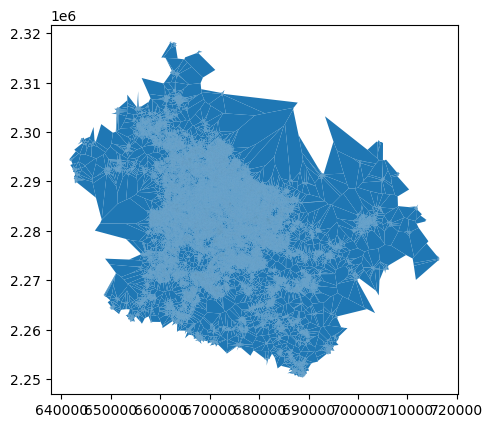

In [7]:
voronois_gdf.plot()

## Assign blocks population data to voronois

In [8]:
print(f"--- Assigning pop col {pop_col} from blocks to voronois .")

#Time start
time_1 = time.time()
#Process
voronois_pop_gdf = src.assing_blocks_attribute_to_voronoi(blocks_gdf, voronois_gdf, attribute_column=pop_col)
#Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(voronois_pop_gdf.shape)
voronois_pop_gdf.head(2)

--- Assigning pop col pobtot from blocks to voronois .
TIME: 19.535787105560303 seconds.
(124423, 3)


,osmid,geometry,pobtot
0,71631182227405376,"POLYGON ((716342.706 2274108.386, 716336.517 2...",0
1,71636649227405032,"POLYGON ((716434.117 2274062.834, 716416.923 2...",0


## Calculate pop density in nodes (Using it's voronoi polygon's area)

In [9]:
print("--- Adding density using each voronoi polygon's area.")
# Set crs
if voronois_pop_gdf.crs != projected_crs:
    voronois_pop_gdf = voronois_pop_gdf.to_crs(projected_crs)
# Calculate whole voronoi's area
voronois_pop_gdf['area_has'] = voronois_pop_gdf.area/10000
# Calculate density
voronois_pop_gdf['dens_pob_ha'] = voronois_pop_gdf[pop_col] / voronois_pop_gdf['area_has']

# Show
print(voronois_pop_gdf.shape)
voronois_pop_gdf.head(2)

--- Adding density using each voronoi polygon's area.
(124423, 5)


,osmid,geometry,pobtot,area_has,dens_pob_ha
0,71631182227405376,"POLYGON ((716342.706 2274108.386, 716336.517 2...",0,2.039817,0.0
1,71636649227405032,"POLYGON ((716434.117 2274062.834, 716416.923 2...",0,0.644630,0.0


## Save voronoi polygons with population and density data

In [10]:
print(f"Original blocks gdf had {blocks_gdf.pobtot.sum()} habs. When dividing to voronois found {voronois_pop_gdf.pobtot.sum()} habs.")
print(f"Difference of {voronois_pop_gdf.pobtot.sum() - blocks_gdf.pobtot.sum()} habs.")

Original blocks gdf had 5011955 habs. When dividing to voronois found 5010339 habs.
Difference of -1616 habs.


In [12]:
if local_save:
    print("--- Saving result locally.")
    voronois_pop_gdf.to_file(output_dir+"guadalajara_voronois_pop_gdf_a.gpkg")
    print("--- Result saved.")

--- Saving result locally.
--- Result saved.
